# pageview-hourly table

Data source used: `wmf.pageview_hourly` (https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Traffic/Pageview_hourly).

This notebook computes the following quantities:

- The distribution of user hits per country (top k countries) to different Wikipedia projects based on their language, also segmenting the hits by platform type (i.e. access method). We considered the top 10 most spoken languages worldwide, which include priority languages for the Search Platform team. When generating the charts, bots and automated traffic were filtered out (i.e., agent_type = "user") and only valid (i.e., non-null) page ids were considered. The countries are ranked according to the total number of user hits.

- A usage measure for the different Wikipedia, given by the number of hits normalized by the size (in number of words) of the page.



## Create spark session

In [1]:
import os, sys
import re
from scipy import stats

import findspark
findspark.init('/usr/lib/spark2')
from pyspark.sql import SparkSession
from pyspark.sql import functions as F, types as T, Window
import wmfdata.spark as wmfspark

# defining the spark session
spark_config = {}
spark = wmfspark.get_session(
    app_name='Pyspark notebook | bscarone (WMF)', 
    type='regular'
    # extra_settings=spark_config
)
spark

You are using wmfdata v1.3.2, but v1.3.3 is available.

To update, run `pip install --upgrade git+https://github.com/wikimedia/wmfdata-python.git@release --ignore-installed`.

To see the changes, refer to https://github.com/wikimedia/wmfdata-python/blob/release/CHANGELOG.md
PySpark executors will use /usr/lib/anaconda-wmf/bin/python3.


PYSPARK_PYTHON=/usr/lib/anaconda-wmf/bin/python3


SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/lib/spark2/jars/slf4j-log4j12-1.7.16.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/lib/hadoop/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/08/11 17:38:00 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
22/08/11 17:38:01 WARN Utils: Service 'sparkDriver' could not bind on port 12000. Attempting port 12001.
22/08/11 17:38:01 WARN Utils: Service 'sparkDriver' could not bind on port 12001. Attempting port 12002.
22/08/11 17:38:01 

In [92]:
print('PySpark Version :'+spark.version)

PySpark Version :2.4.4


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Types of queries
- Given a country, list the number of hits per language, when the number of hits is higher than a certain threshold.
- Given a language, list the number of hits of that language per coutry, when the number of hits is higher than a certain threshold.

# Query: Language -> hits per country

In [94]:
# set language
lan = 'English'

In [22]:
# set temporal granularity
year = 2020
month = 10
day = 5
hour = 2

In [96]:
# load list of wikipedias
df_wikis = spark.read.csv("wikipedias_cropped.csv", sep=',', inferSchema=True, header=True)
df_wikis.printSchema()

[Stage 163:>                                                        (0 + 1) / 1]

root
 |-- Nr: integer (nullable = true)
 |-- Language: string (nullable = true)
 |-- Language (local): string (nullable = true)
 |-- Wiki: string (nullable = true)
 |-- Good: integer (nullable = true)
 |-- Total: integer (nullable = true)
 |-- Edits: integer (nullable = true)
 |-- Admins: integer (nullable = true)
 |-- Users: integer (nullable = true)
 |-- Active Users: integer (nullable = true)
 |-- Files: integer (nullable = true)
 |-- Stub Ratio: double (nullable = true)
 |-- Version: string (nullable = true)
 |-- License: string (nullable = true)
 |-- Archive: string (nullable = true)
 |-- HTTP: integer (nullable = true)
 |-- ID: integer (nullable = true)
 |-- mt: integer (nullable = true)
 |-- Last update: string (nullable = true)



In [97]:
df_wikis = df_wikis.drop("Language (local)", "HTTP", "Good", "Total", "Edits", "License", "Admins", "Last update")

In [98]:
df_wikis.show()

[Stage 164:>                                                        (0 + 1) / 1]

+---+---------------+----+--------+------------+------+----------+-------------+-------+---+---+
| Nr|       Language|Wiki|   Users|Active Users| Files|Stub Ratio|      Version|Archive| ID| mt|
+---+---------------+----+--------+------------+------+----------+-------------+-------+---+---+
|  1|        English|  en|43848316|      118305|894010|    0.1162|1.39.0-wmf.16|archive|  2|  8|
|  2|        Cebuano| ceb|   91542|         173|     0|    0.5454|1.39.0-wmf.16|archive|153|  8|
|  3|         German|  de| 3947413|       17446|128572|    0.3621|1.39.0-wmf.16|archive| 10|  8|
|  4|        Swedish|  sv|  825828|        2051|     0|    0.4175|1.39.0-wmf.16|archive| 16|  8|
|  5|         French|  fr| 4406977|       17874| 68725|    0.2014|1.39.0-wmf.16|archive|  1|  8|
|  6|          Dutch|  nl| 1215430|        3923|    20|      0.47|1.39.0-wmf.16|archive|  8|  8|
|  7|        Russian|  ru| 3204548|       10847|236838|    0.2479|1.39.0-wmf.16|archive| 24|  8|
|  8|        Spanish|  es| 657

In [99]:
# get hits for wikipedia(lan) per country

# get wikipedia(lan), i.e. wikipedia of language 'lan'
wiki_prefix = df_wikis.select("Wiki").where(df_wikis.Language == lan).collect()[0]["Wiki"]

In [100]:
wiki_prefix

'en'

In [101]:
project = wiki_prefix + ".wikipedia"
project

'en.wikipedia'

In [25]:
df_pageview_hourly = (
    spark.read.table("wmf.pageview_hourly")
    # select time window
    .where(F.col("year")==year)
    .where(F.col("month")==month)
)
df_pageview_hourly.printSchema()

root
 |-- project: string (nullable = true)
 |-- language_variant: string (nullable = true)
 |-- page_title: string (nullable = true)
 |-- access_method: string (nullable = true)
 |-- zero_carrier: string (nullable = true)
 |-- agent_type: string (nullable = true)
 |-- referer_class: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- country: string (nullable = true)
 |-- subdivision: string (nullable = true)
 |-- city: string (nullable = true)
 |-- user_agent_map: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- record_version: string (nullable = true)
 |-- view_count: long (nullable = true)
 |-- page_id: integer (nullable = true)
 |-- namespace_id: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)



In [27]:
df_pageview_hourly.select("access_method").distinct().show()

+-------------+
|access_method|
+-------------+
|      desktop|
|   mobile app|
|   mobile web|
+-------------+



In [102]:
df_wiki_hits = (
    spark.read.table("wmf.pageview_hourly")
    # select time window
    .where(F.col("year")==year)
    .where(F.col("month")==month)
    # .where(F.col("day")==day)
    # .where(F.col("hour")==hour)
    
    # filter bots and automated traffic
    .where(F.col("agent_type") == "user")

    # only valid pageids
    .where(F.col("page_id").isNotNull())
    
    # only target wiki
    .where(F.col("project") == project)
    
    .select("country","project")
    # count access methods
    .groupBy("country","project")
    .count()
)
df_wiki_hits_filtered = df_wiki_hits.orderBy(F.col("count").desc()).limit(20).drop("project")
# can be normalized by population
df_wiki_hits_filtered.show()

[Stage 168:====================================================>(254 + 2) / 256]

+--------------+----------+
|       country|     count|
+--------------+----------+
| United States|2753354368|
|United Kingdom| 732453967|
|         India| 569147913|
|        Canada| 332750783|
|     Australia| 215921534|
|   Philippines| 144896922|
|       Germany| 128202921|
|     Indonesia|  67452151|
|   Netherlands|  65187111|
|       Ireland|  60510824|
|      Malaysia|  57790409|
|        France|  54933333|
|     Singapore|  52324312|
|        Brazil|  50292721|
|        Sweden|  49764855|
|         Italy|  49397527|
|  South Africa|  48261591|
|        Russia|  45639243|
|        Poland|  39742058|
|         Spain|  39620606|
+--------------+----------+



Text(0.5, 1.0, 'User hits to en.wikipedia per country (top 20) on 10/2020')

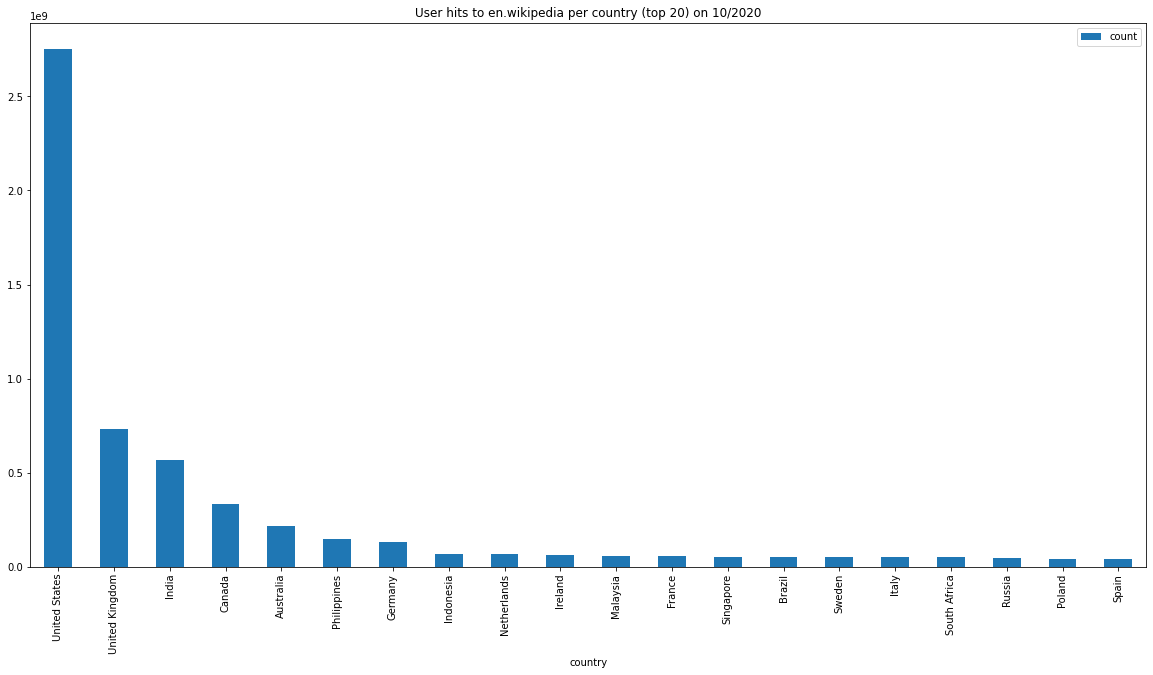

In [104]:
df_wiki_hits_filtered.toPandas().plot.bar(x="country", y="count", figsize=(20, 10))
plt.title("User hits to "+project+" per country (top 20) on {}/{}".format(month,year))
# color by continent?

# Modularization

In [17]:
# df_wikis = (
#     spark.read.table("canonical_data.wikis")
# ).select("database_group","language_code","language_name")

In [70]:
df_wiki_hits_topk = (
    spark.read.table("wmf.pageview_hourly")
    # select time window
    .where(F.col("year")==year)
    .where(F.col("month")==month)
    .where(F.col("day")==12)

    # filter bots and automated traffic
    .where(F.col("agent_type") == "user")
    # only valid pageids
    .where(F.col("page_id").isNotNull())
    # only target wiki
    .where(F.col("project") == "en.wikipedia")
    .select("country","project")
    # count 
    .groupBy("country","project")
    .count()
).orderBy(F.col("count").desc()).limit(20).drop("project")
df_wiki_hits_topk.show()

[Stage 213:======================================>              (185 + 4) / 256]

+--------------+--------+
|       country|   count|
+--------------+--------+
| United States|96444479|
|United Kingdom|23481674|
|         India|19669390|
|        Canada|11746192|
|     Australia| 7062787|
|   Philippines| 5409687|
|       Germany| 4258900|
|     Indonesia| 2385177|
|   Netherlands| 2154142|
|       Ireland| 1967762|
|        France| 1876224|
|      Malaysia| 1784954|
|         Italy| 1692466|
|     Singapore| 1690653|
|  South Africa| 1668622|
|        Brazil| 1668534|
|        Sweden| 1667885|
|         Spain| 1400446|
|        Poland| 1357890|
|   New Zealand| 1266824|
+--------------+--------+



In [86]:
df_wiki_hits_topk_2 = (
    spark.read.table("wmf.pageview_hourly")
    # select time window
    .where(F.col("year")==year)
    .where(F.col("month")==month)
    .where(F.col("day")==12)

    # filter bots and automated traffic
    .where(F.col("agent_type") == "user")
    # only valid pageids
    .where(F.col("page_id").isNotNull())
    # only target wiki
    .where(F.col("project") == "en.wikipedia")
    .select("country","project","access_method")
    # count 
    .groupBy("country","project")
    .pivot("access_method")
    .count()
).drop("project").fillna(0)#.orderBy(F.col("count").desc()).limit(20)
df_wiki_hits_topk_2 = df_wiki_hits_topk_2.withColumn("total", F.col("desktop")+F.col("mobile app")+F.col("mobile web"))
df_wiki_hits_topk_2.orderBy(F.col("total").desc()).limit(20).show()
# df_p = df_wiki_hits_topk.toPandas().pivot(index="country",columns="access_method",values="count")
# df_p["total"] = df_p["desktop"] + df_p["mobile web"]
# display(df_p.sort_values(by=['total'],ascending=False))
# .orderBy(F.col("count").desc()).limit(20)


[Stage 311:====================================================>(252 + 4) / 256]

+--------------+--------+----------+----------+--------+
|       country| desktop|mobile app|mobile web|   total|
+--------------+--------+----------+----------+--------+
| United States|37072868|     20740|  59350871|96444479|
|United Kingdom| 9176915|      6536|  14298223|23481674|
|         India| 4218901|      3444|  15447045|19669390|
|        Canada| 4483020|      2745|   7260427|11746192|
|     Australia| 3319016|      1138|   3742633| 7062787|
|   Philippines| 2008322|       488|   3400877| 5409687|
|       Germany| 2727128|       919|   1530853| 4258900|
|     Indonesia|  780283|       375|   1604519| 2385177|
|   Netherlands| 1329382|       452|    824308| 2154142|
|       Ireland|  660365|       420|   1306977| 1967762|
|        France| 1209845|       295|    666084| 1876224|
|      Malaysia|  683308|       263|   1101383| 1784954|
|         Italy|  900525|       262|    791679| 1692466|
|     Singapore|  795009|       333|    895311| 1690653|
|  South Africa|  455052|      

In [50]:
def top_k_hits_per_country(k, lan, year, month, path):
    # load list of wikipedias
    df_wikis = spark.read.csv("wikipedias_cropped.csv", sep=',', inferSchema=True, header=True).select("Language", "Wiki")
    
    # get wikipedia(lan), i.e. wikipedia of language 'lan'
    wiki_prefix = df_wikis.select("Wiki").where(df_wikis.Language == lan).collect()[0]["Wiki"]
    
    project = wiki_prefix + ".wikipedia"

    df_wiki_hits_topk = (
        spark.read.table("wmf.pageview_hourly")
        # select time window
        .where(F.col("year")==year)
        .where(F.col("month")==month)
        # .where(F.col("day")==12)

        # filter bots and automated traffic
        .where(F.col("agent_type") == "user")
        # only valid pageids
        .where(F.col("page_id").isNotNull())
        # only target wiki
        .where(F.col("project") == project)
        .select("country","project","access_method")
        # count 
        .groupBy("country","project")
        .pivot("access_method")
        .count()
    ).drop("project").fillna(0)
    
    # changed from F.col("desktop")+F.col("mobile app")+F.col("mobile web") to 
    # sum(df[col] for col in df.columns.remove("country")) to fix bug when one of the coulmns did not exist
    non_country_cols = df_wiki_hits_topk.columns
    non_country_cols.remove("country")
    df_wiki_hits_topk = df_wiki_hits_topk.withColumn("total", sum(df_wiki_hits_topk[col] for col in non_country_cols))
    df_wiki_hits_topk.show()
    
    df_wiki_hits_topk.orderBy(F.col("total").desc()).limit(k)#.show()
    
    df_pd = df_wiki_hits_topk.orderBy(F.col("total").desc()).limit(k).toPandas()
    df_pd.sort_values("total", inplace=True)
    df_pd.plot.barh(x="country", y=non_country_cols, figsize=(20, 10))
    plt.title("User hits to {} ({}) per country (top {}) on {}/{}".format(project,lan,k,month,year), fontsize = 18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(path+'/{}{}/{}_hits_per_country_top{}_accessmethod_{}{}_barh.pdf'.format(month,year,wiki_prefix,k,year,month))

    
    # df_p.plot.bar(x="country", y=["desktop","mobile web"], figsize=(20, 10))
    # ax = df_wiki_hits_topk.toPandas().plot.bar(x="country", y="count", figsize=(20, 10))
    # ax.set_title("User hits to {} ({}) per country (top {}) on {}/{}".format(project,lan,k,month,year))
    # ax.figure.savefig(path+'/{}_hits_per_country_top{}_accessmethod_{}{}.pdf'.format(wiki_prefix,k,year,month))
    

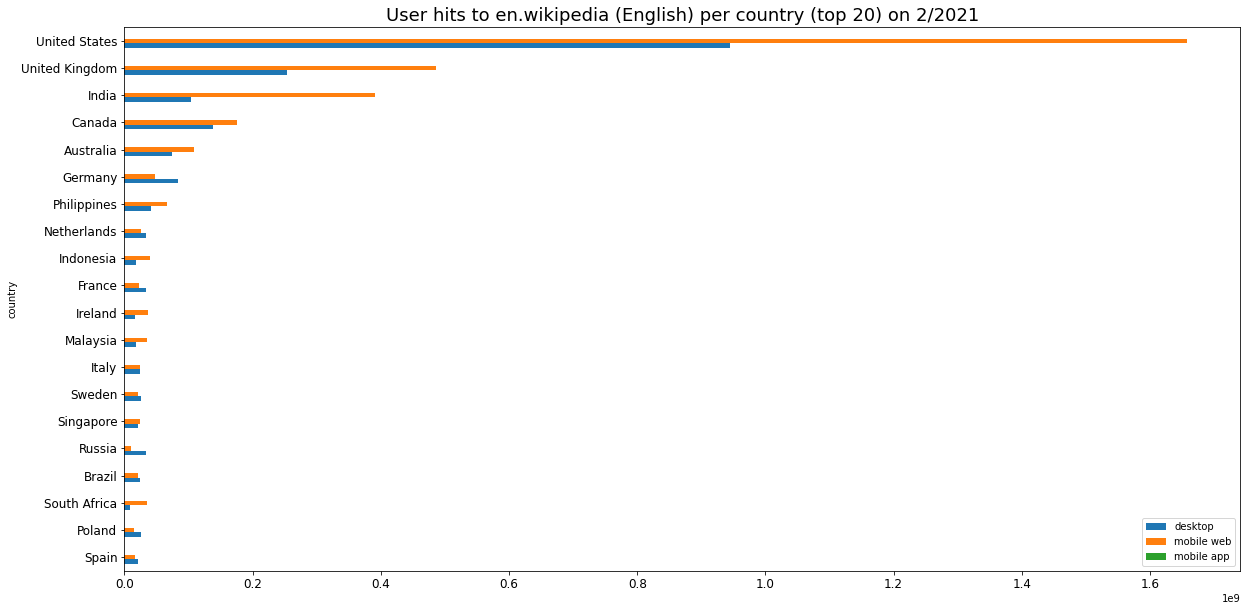

In [14]:
top_k_hits_per_country(20, "English", 2021, 2, "/home/bscarone/search-metrics/hits-per-country/output")

+--------------------+--------+----------+---------+
|             country| desktop|mobile web|    total|
+--------------------+--------+----------+---------+
|        Saint Helena|      22|         7|       29|
|             Germany|67512399|  52237468|119749867|
|               Nauru|    2020|      9150|    11170|
|French Southern T...|      18|         0|       18|
|              Guyana|  159061|    350248|   509309|
|               Syria|  203590|    393794|   597384|
|              Zambia|  326680|   1359327|  1686007|
|            Tanzania|  512124|   2366495|  2878619|
|              Belize|  122642|    197479|   320121|
|             Unknown| 2300553|   1695336|  3995889|
|             Finland|12340828|  15297742| 27638570|
|          Uzbekistan| 2418657|   1021372|  3440029|
|            Suriname|  117568|    279578|   397146|
|     Solomon Islands|   23276|     47475|    70751|
|               Sudan|  123040|    601267|   724307|
|              Russia|26176984|  16544120| 427

FileNotFoundError: [Errno 2] No such file or directory: '/home/bscarone/search-metrics/hits-per-country/output/72022/en_hits_per_country_top15_accessmethod_20227_barh.pdf'

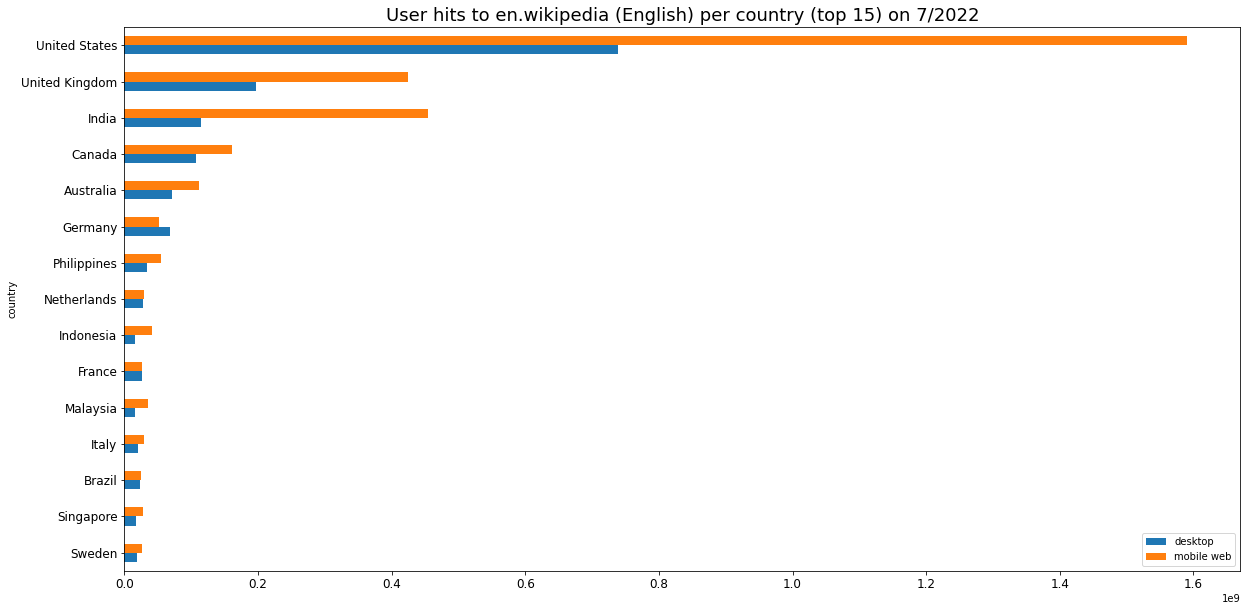

In [51]:
top_k_hits_per_country(15, "English", 2022, 7, "/home/bscarone/search-metrics/hits-per-country/output")

From https://phabricator.wikimedia.org/T301902

Languages of interest
We are interested in the following emerging languages for the search experimentations:

Priority 1:

- Arabic
- Bengali*
- Spanish
- Portuguese*
- Russian

Priority 2:

- French*
- Korean*
- Indonesian
- Ukrainian
- Thai*
- Malaysian (?)
- Hindi
- Tagalog
- Afrikaans
- Cantonese
- Malayalam
- Telugu
*These languages are part of wikis to avoid (below)

Language English starts


Language Chinese starts


Language Hindi starts


Language Spanish starts


Language French starts


Language Arabic starts


Language Bengali starts


Language Russian starts


Language Portuguese starts


Language Indonesian starts


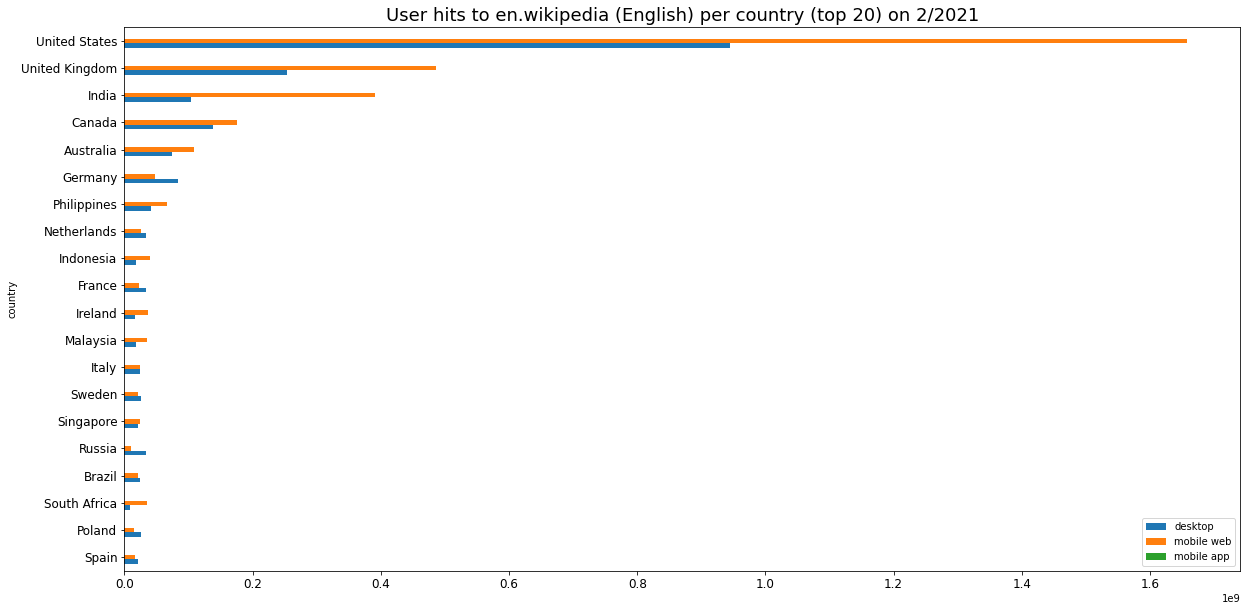

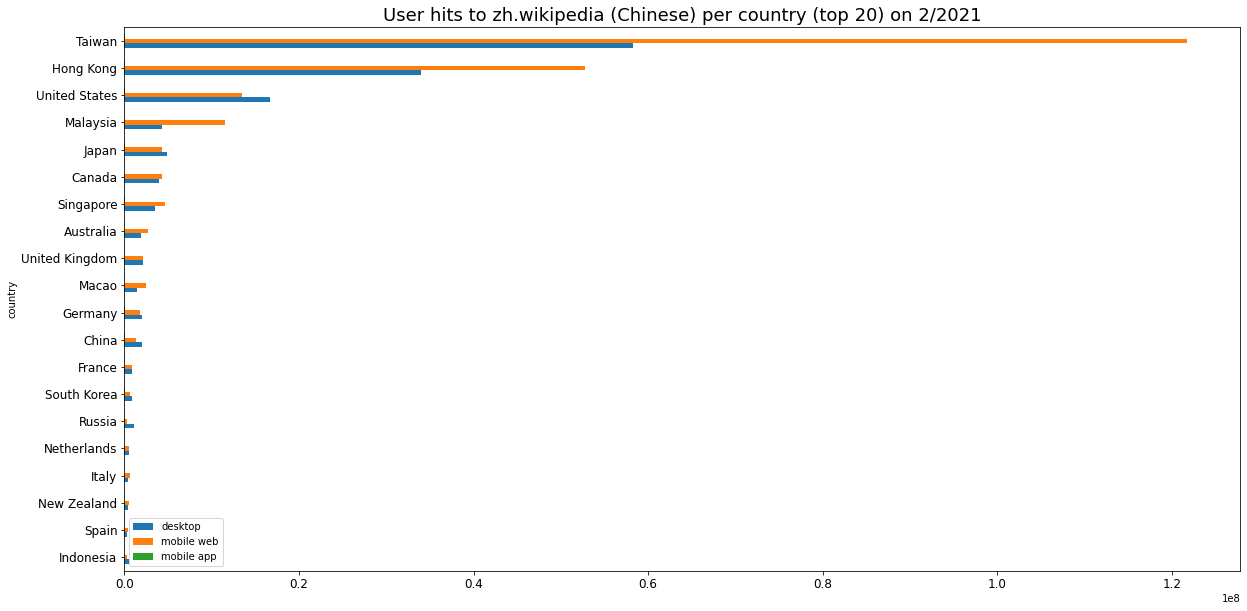

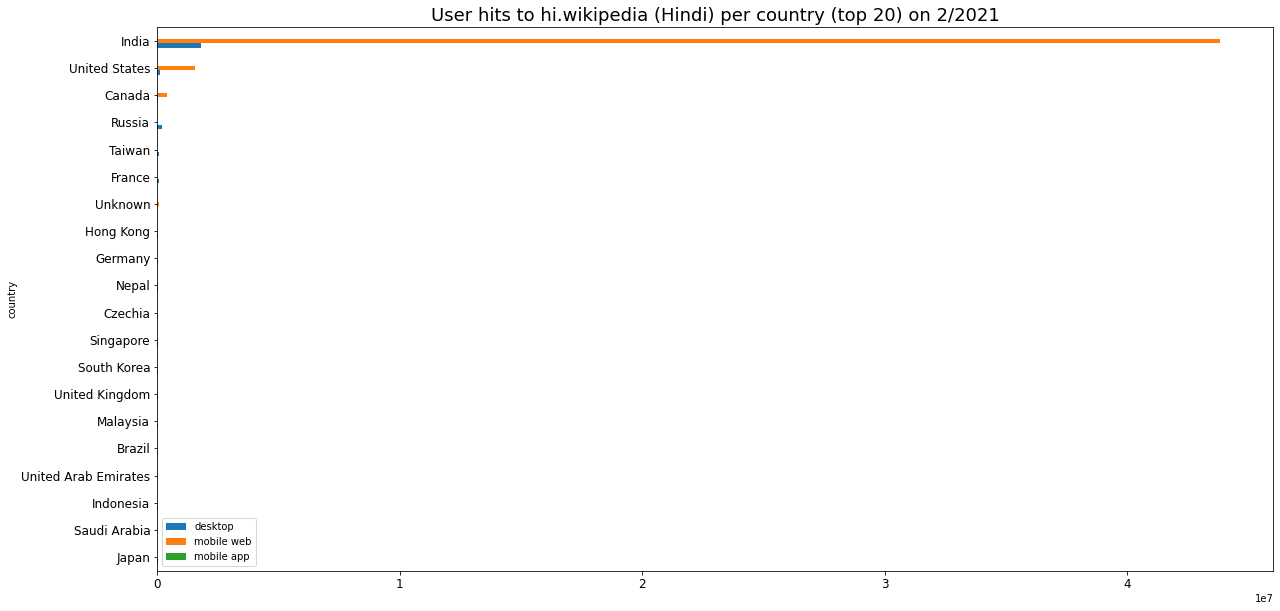

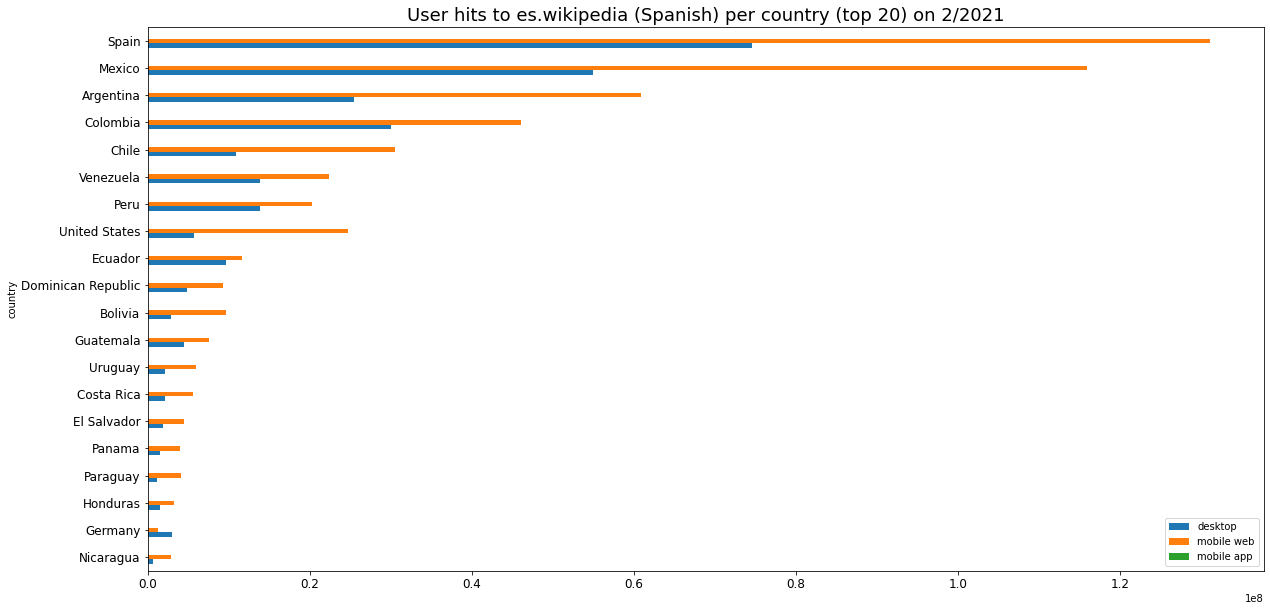

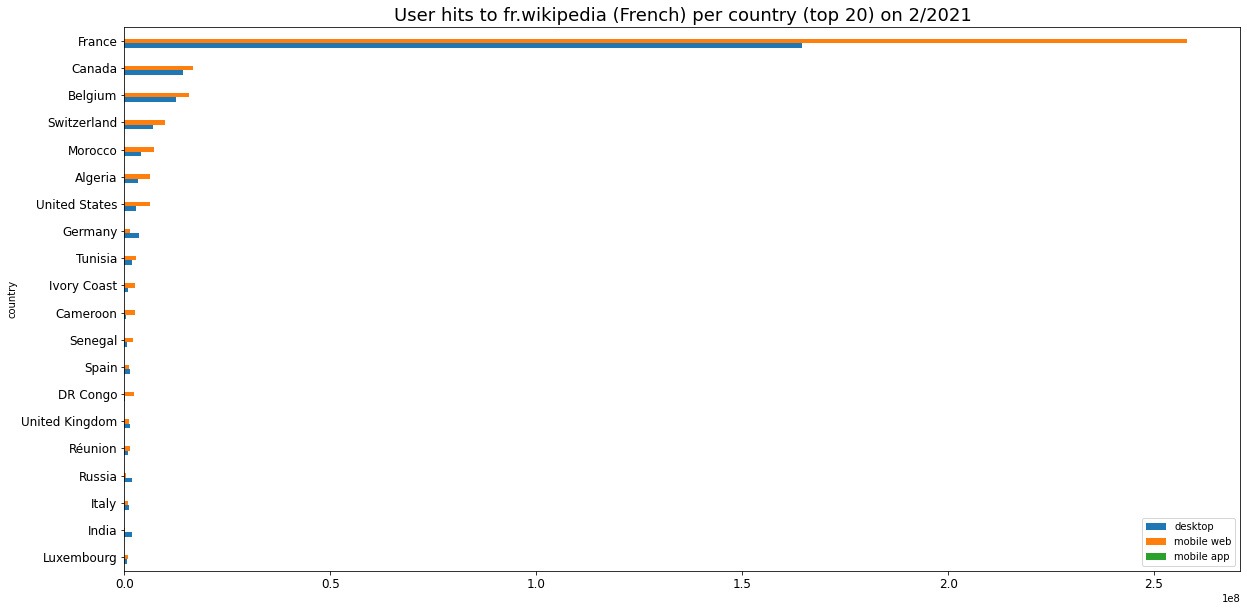

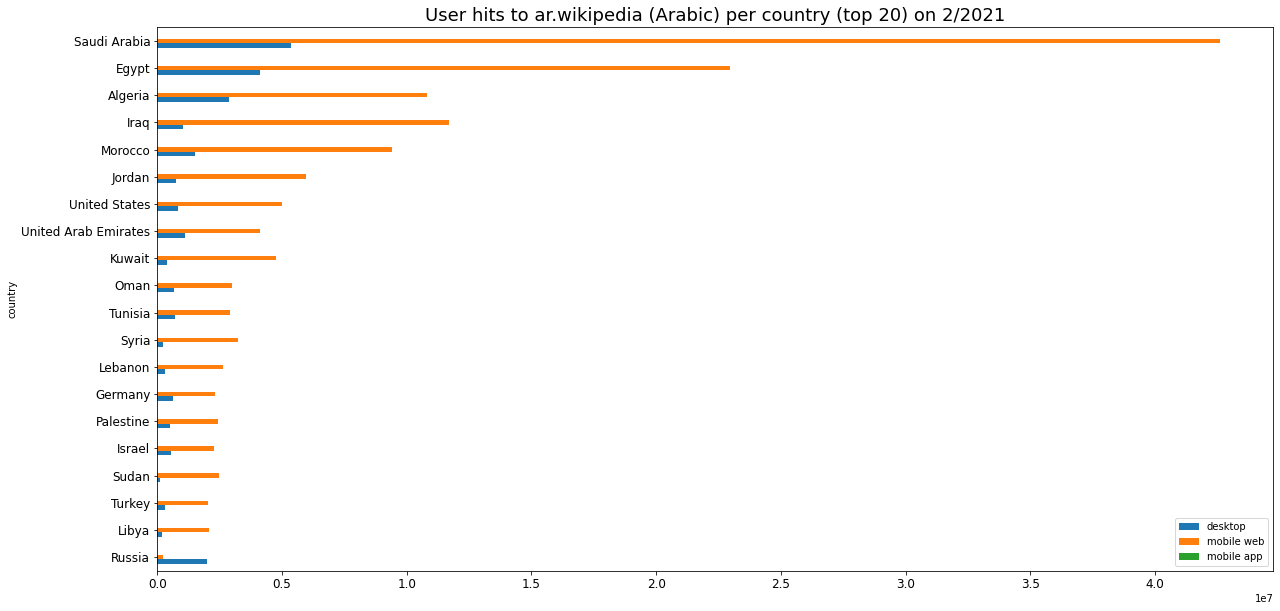

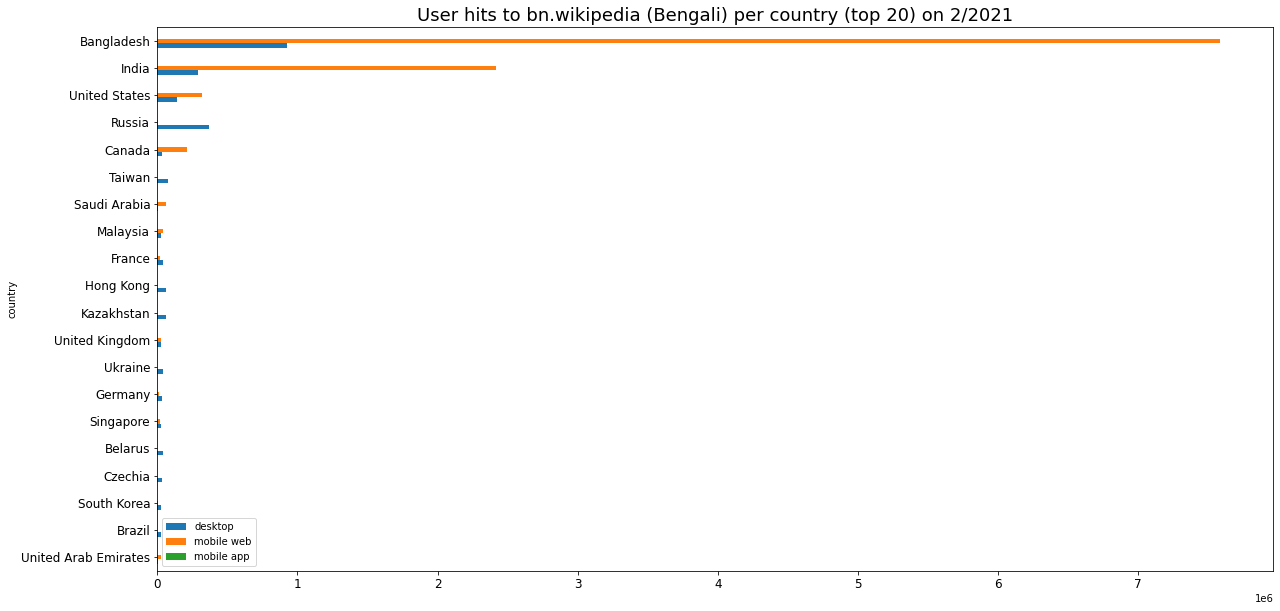

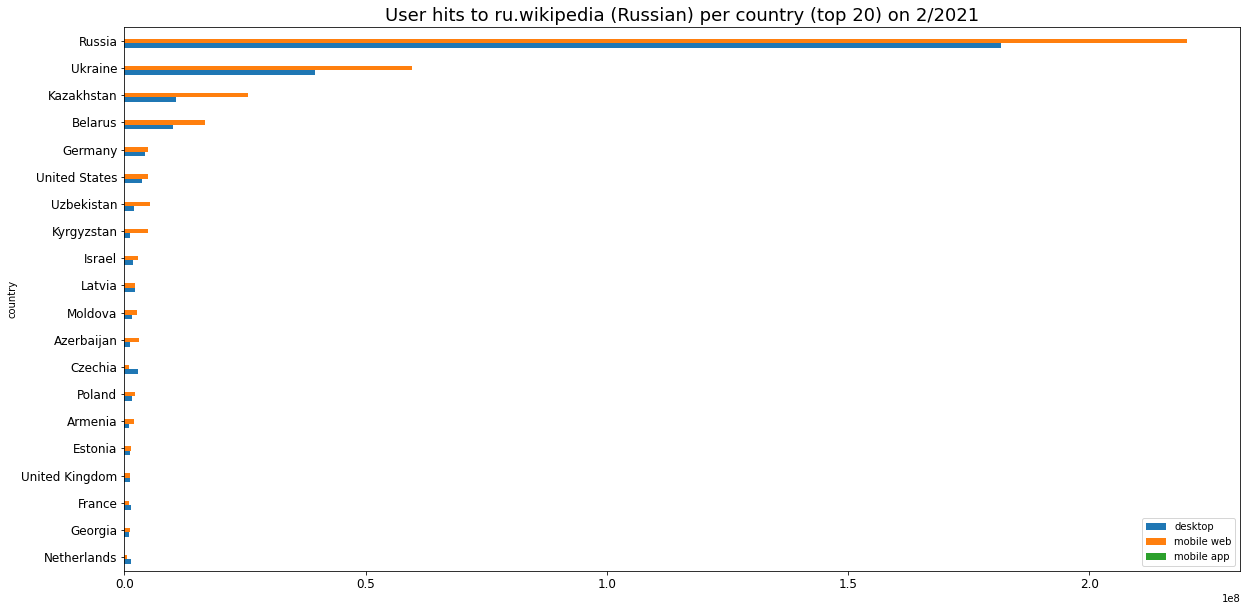

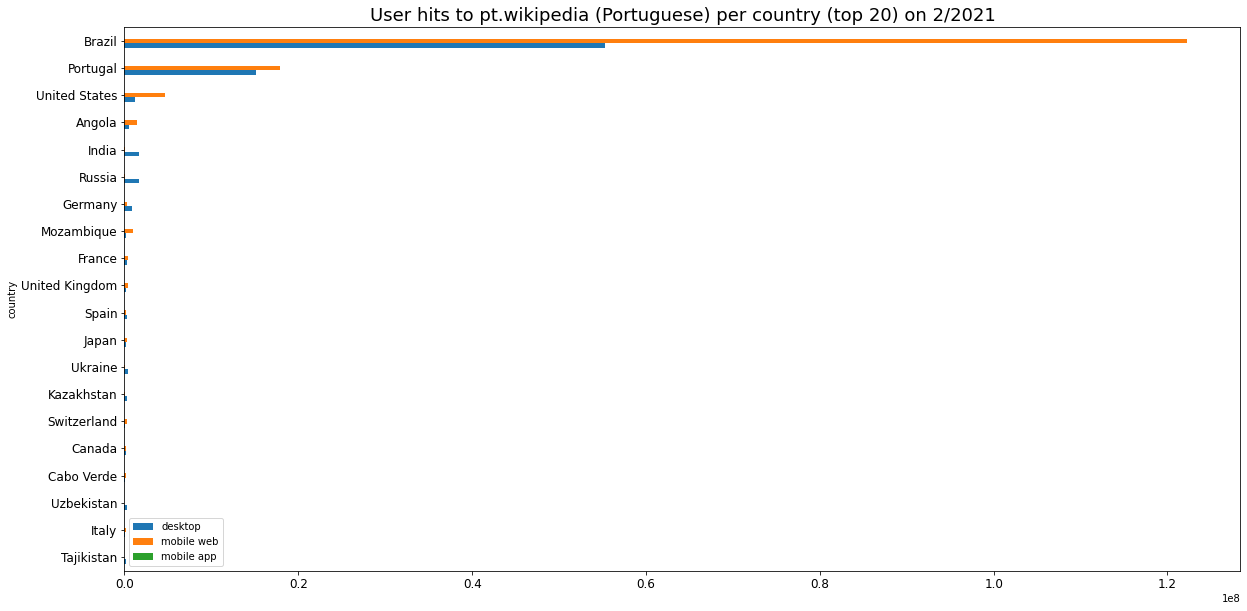

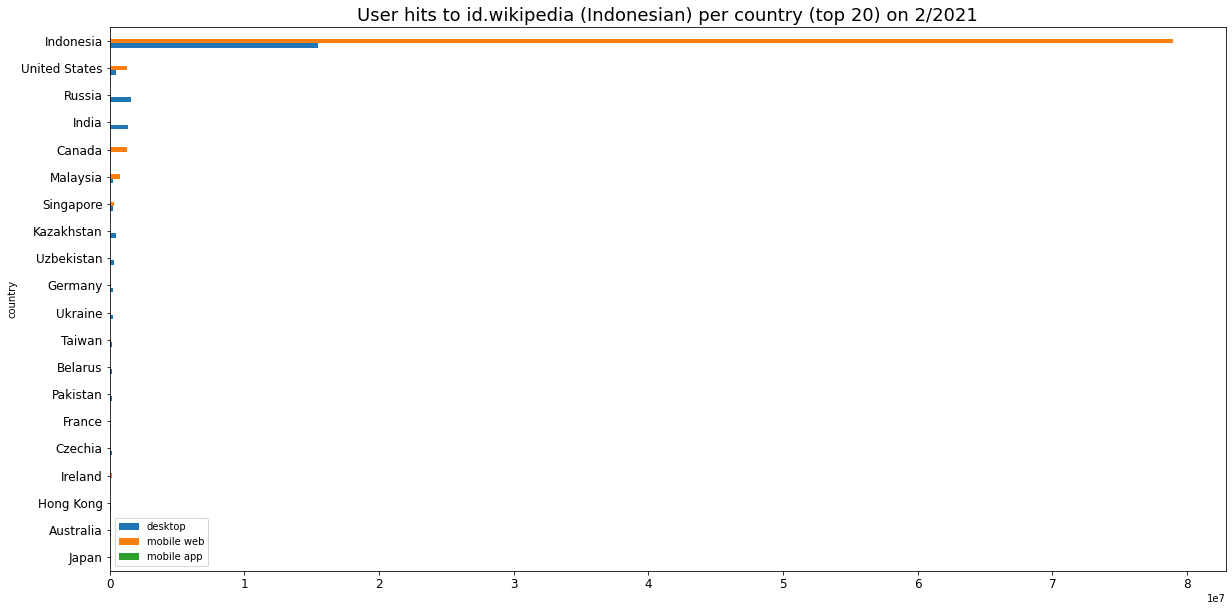

In [5]:
# https://www.berlitz.com/blog/most-spoken-languages-world
# k=20
languages = ["English", "Chinese", "Hindi", "Spanish", "French", "Arabic", "Bengali", "Russian", "Portuguese", "Indonesian"] # includes Priority 1 languages
for lan in languages:
    print("Language {} starts".format(lan))
    top_k_hits_per_country(20, lan, 2021, 2, "/home/bscarone/search-metrics/hits-per-country/output")

In [ ]:
# k=15
languages = ["English", "Chinese", "Hindi", "Spanish", "French", "Arabic", "Bengali", "Russian", "Portuguese", "Indonesian"] # includes Priority 1 languages
for lan in languages:
    print("Language {} starts".format(lan))
    top_k_hits_per_country(15, lan, 2022, 7, "/home/bscarone/search-metrics/hits-per-country/output")

Language English starts


+--------------------+--------+----------+---------+
|             country| desktop|mobile web|    total|
+--------------------+--------+----------+---------+
|             Germany|67512399|  52237468|119749867|
|        Saint Helena|      22|         7|       29|
|               Nauru|    2020|      9150|    11170|
|French Southern T...|      18|         0|       18|
|              Guyana|  159061|    350248|   509309|
|               Syria|  203590|    393794|   597384|
|              Zambia|  326680|   1359327|  1686007|
|             Unknown| 2300553|   1695336|  3995889|
|              Belize|  122642|    197479|   320121|
|            Tanzania|  512124|   2366495|  2878619|
|          Uzbekistan| 2418657|   1021372|  3440029|
|             Finland|12340828|  15297742| 27638570|
|     Solomon Islands|   23276|     47475|    70751|
|            Suriname|  117568|    279578|   397146|
|               Sudan|  123040|    601267|   724307|
|              Russia|26176984|  16544120| 427

Language Chinese starts


+--------------------+-------+----------+------+
|             country|desktop|mobile web| total|
+--------------------+-------+----------+------+
|   Wallis and Futuna|      2|         0|     2|
|               Nauru|     52|       186|   238|
|          Madagascar|   1474|      3663|  5137|
|        South Africa|  16837|     45333| 62170|
|              Angola|   3174|      7524| 10698|
|               India| 104675|    139048|243723|
|          Azerbaijan|   2182|      4738|  6920|
|                Mali|    399|      2192|  2591|
|St Vincent and Gr...|    197|       264|   461|
|              Mexico|  37277|     84934|122211|
|            Portugal|  26733|     71913| 98646|
|               Haiti|    322|       888|  1210|
|             Tokelau|      0|         2|     2|
|               Benin|    831|      2259|  3090|
|                Iraq|   7537|     16338| 23875|
|              Brunei|   9018|     27573| 36591|
|Turks and Caicos ...|     12|       358|   370|
|            Dominic

Language Hindi starts


[Stage 523:==========================================>        (1578 + 4) / 1895]

## Usage metric

In [83]:
def usage(lan, year, month, day):
    # load list of wikipedias
    df_wikis = spark.read.csv("wikipedias_cropped.csv", sep=',', inferSchema=True, header=True).select("Language", "Wiki")
    # get wikipedia(lan), i.e. wikipedia of language 'lan'
    wiki_prefix = df_wikis.select("Wiki").where(df_wikis.Language == lan).collect()[0]["Wiki"]
    project = wiki_prefix + ".wikipedia"

    # load csv with nr of words
    df_nrwords = spark.read.csv("size_nrwords_wikis_080822.csv", sep=',', inferSchema=True, header=True)

    df_wiki_hits_project = (
        spark.read.table("wmf.pageview_hourly")
        .select("project","access_method")
        # select time window
        .where(F.col("year")==year)
        .where(F.col("month")==month)
        .where(F.col("day").between(day,day+6))

        # filter bots and automated traffic
        .where(F.col("agent_type") == "user")
        # only valid pageids
        .where(F.col("page_id").isNotNull())
        # only target wiki
        .where(F.col("project") == project)
        # count 
        .groupBy("project")
        .pivot("access_method")
        .count()
    ).drop("language").fillna(0)
    
    # join with statistics (nr of words) on project
    df_wiki_hits_project_nrwords = df_wiki_hits_project.join(df_nrwords, df_wiki_hits_project.project == df_nrwords.project, "inner")\
                                                        .drop(df_nrwords.project)
    # df_wiki_hits_project_nrwords.show()
    cols_am = df_wiki_hits_project_nrwords.columns
    cols_am.remove("project")
    cols_am.remove("nr_words")
    cols_am.remove("language")
    df_wiki_hits_project_nrwords = df_wiki_hits_project_nrwords.withColumn("total", sum(df_wiki_hits_project[col] for col in cols_am))
    cols_am.append("total")
    for col in cols_am:
        df_wiki_hits_project_nrwords = df_wiki_hits_project_nrwords.withColumn(f'''usage_{col}''', F.round(F.col(f'''{col}''')/F.col("nr_words"),3))
    # df_wiki_hits_project_nrwords.show()
    
    return df_wiki_hits_project_nrwords

In [79]:
usage("English", 2022, 7, 4)

[Stage 889:====================================================> (98 + 2) / 100]

+------------+---------+----------+--------+----------+----------+-------------+----------------+-----------+
|     project|  desktop|mobile web|language|  nr_words|     total|usage_desktop|usage_mobile web|usage_total|
+------------+---------+----------+--------+----------+----------+-------------+----------------+-----------+
|en.wikipedia|447968997| 849817209| English|4180601186|1297786206|        0.107|           0.203|       0.31|
+------------+---------+----------+--------+----------+----------+-------------+----------------+-----------+



In [89]:
languages = ["English", "Chinese", "Hindi", "Spanish", "French", "Arabic", "Bengali", "Russian", "Portuguese", "Indonesian"] # includes Priority 1 languages
df_wiki_usage = []
for lan in languages:
    print("Language {} starts".format(lan))
    if df_wiki_usage == []:
        df_wiki_usage = usage(lan, 2022, 7, 4)
    else:
        df_aux = usage(lan, 2022, 7, 4)
        df_wiki_usage = df_wiki_usage.union(df_aux)

Language English starts


Language Chinese starts


Language Hindi starts


Language Spanish starts


Language French starts


Language Arabic starts


Language Bengali starts


Language Russian starts


Language Portuguese starts


Language Indonesian starts


In [95]:
# plot results
df_wiki_usage = df_wiki_usage.withColumnRenamed("mobile web","mobile_web")
df_wiki_usage = df_wiki_usage.withColumnRenamed("usage_mobile web","usage_mobile_web")
df_wiki_usage.show(10,False)
df_wiki_usage.write.mode("overwrite").parquet('df_usage_metric_amethod_4-1072022_r08082022.parquet')

+------------+---------+----------+----------+----------+----------+-------------+----------------+-----------+
|project     |desktop  |mobile_web|language  |nr_words  |total     |usage_desktop|usage_mobile_web|usage_total|
+------------+---------+----------+----------+----------+----------+-------------+----------------+-----------+
|en.wikipedia|447968997|849817209 |English   |4180601186|1297786206|0.107        |0.203           |0.31       |
|zh.wikipedia|18099381 |54640419  |Chinese   |606302164 |72739800  |0.03         |0.09            |0.12       |
|hi.wikipedia|476894   |9160169   |Hindi     |50154715  |9637063   |0.01         |0.183           |0.192      |
|es.wikipedia|40100818 |99473905  |Spanish   |1056914839|139574723 |0.038        |0.094           |0.132      |
|fr.wikipedia|35112319 |67725574  |French    |1530272385|102837893 |0.023        |0.044           |0.067      |
|ar.wikipedia|3301556  |26976002  |Arabic    |371156178 |30277558  |0.009        |0.073           |0.082

[Stage 2161:=================================================>(2554 + 6) / 2560]425]]]]]

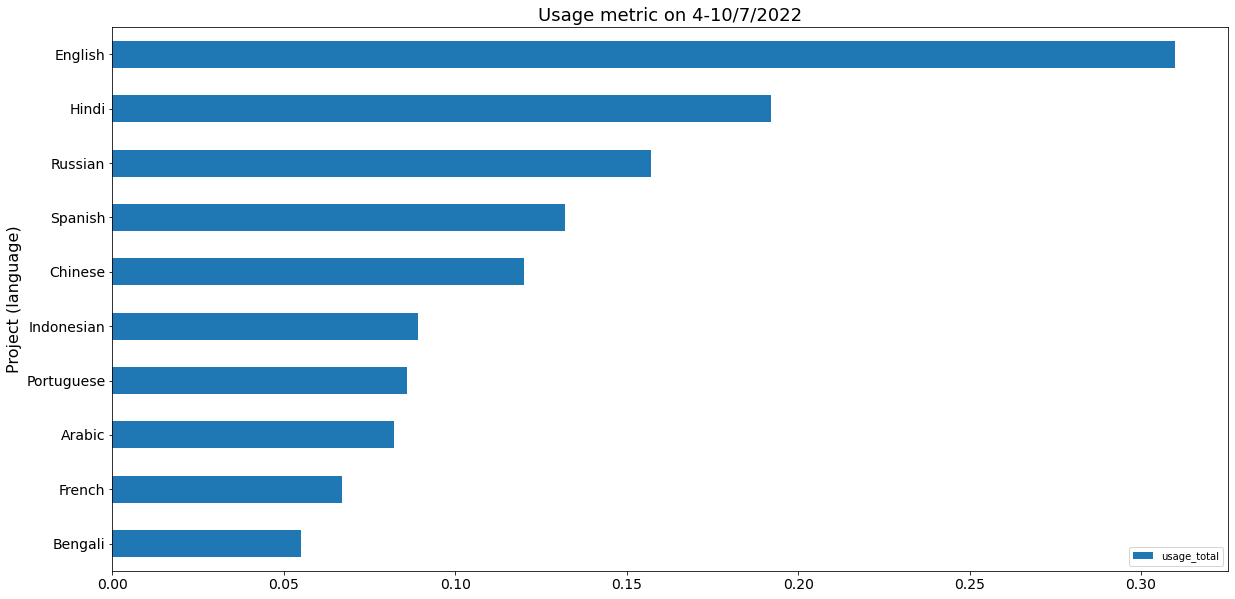

In [101]:
df_pd_wiki_usage = df_wiki_usage.toPandas()
df_pd_wiki_usage.sort_values("usage_total", inplace=True)
df_pd_wiki_usage.plot.barh(x="language", y="usage_total", figsize=(20, 10))
plt.title(f"Usage metric on 4-10/7/2022", fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Project (language)", fontsize=16)
plt.savefig(f'/home/bscarone/search-metrics/hits-per-country/output/usage_metric_amethod_4-1072022_barh.pdf', bbox_inches = 'tight')

# df_top15q_mw_2_8522.sort_values("count", inplace=True)
# df_top15q_mw_2_8522.plot.barh(x="Query", y="count", figsize=(20, 10))
# plt.title(f"Top 15 queries - mobile web on 2-8/5/2022", fontsize = 18)
# plt.ylabel("Query", fontsize=16)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# # plt.ylabel("% of total")
# plt.savefig(f'/home/bscarone/search-metrics/top-queries/outputs/top_15_queries_mobile web_2-852022_barh.pdf',bbox_inches = 'tight')

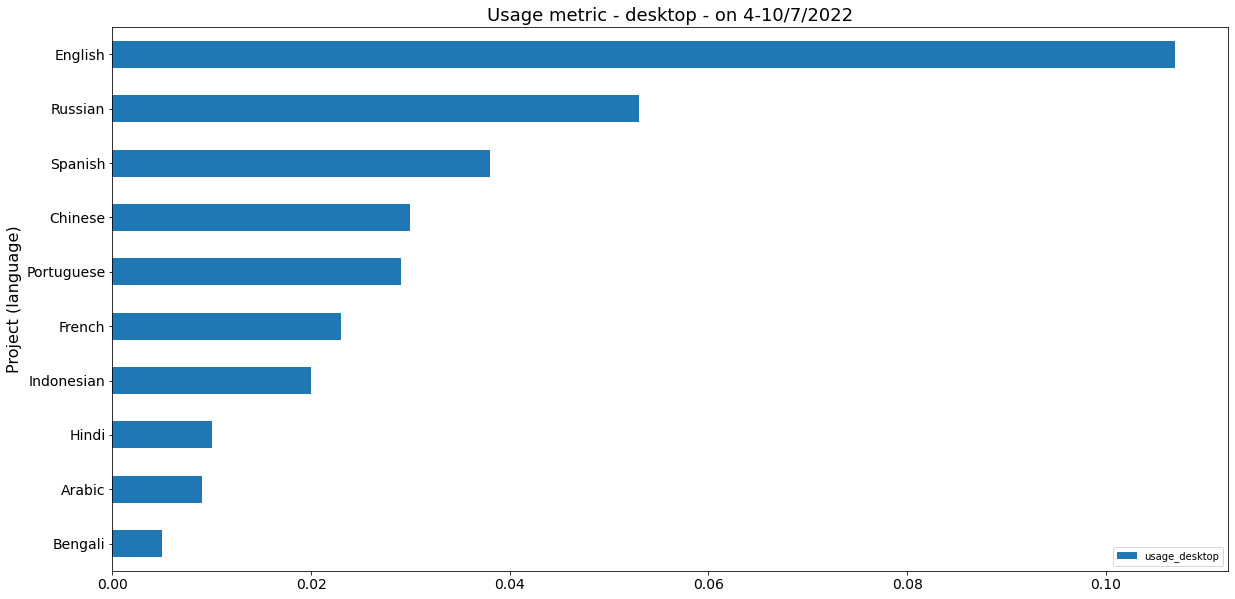

In [102]:
df_pd_wiki_usage = df_wiki_usage.toPandas()
df_pd_wiki_usage.sort_values("usage_desktop", inplace=True)
df_pd_wiki_usage.plot.barh(x="language", y="usage_desktop", figsize=(20, 10))
plt.title(f"Usage metric - desktop - on 4-10/7/2022", fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Project (language)", fontsize=16)
plt.savefig(f'/home/bscarone/search-metrics/hits-per-country/output/usage_metric_desktop_4-1072022_barh.pdf', bbox_inches = 'tight')

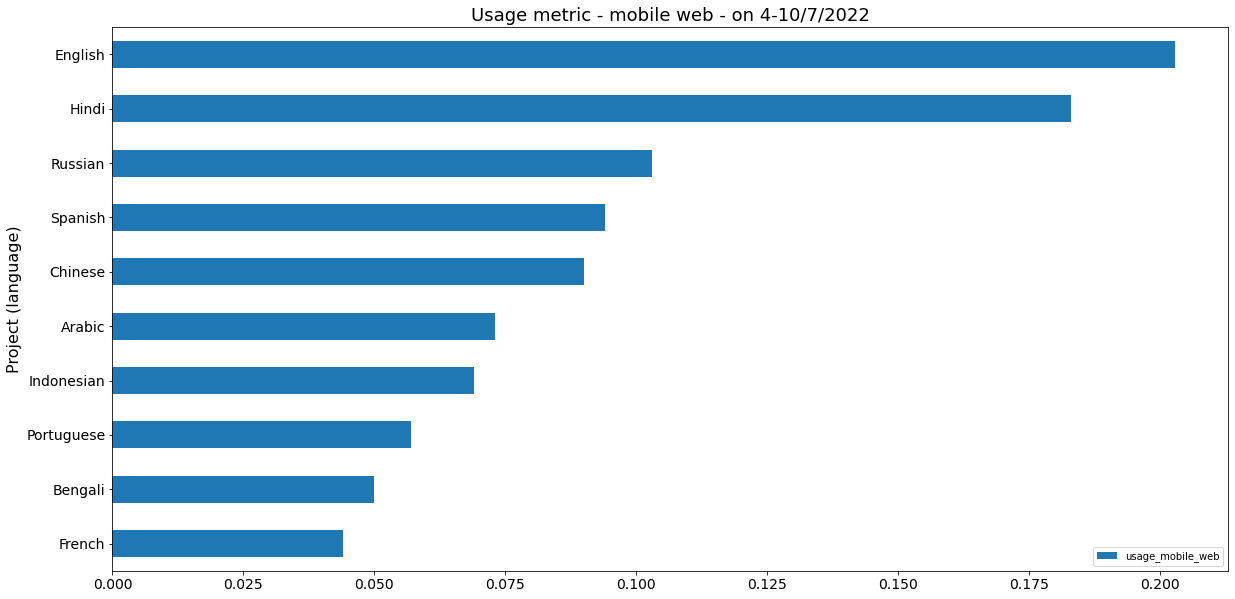

In [103]:
df_pd_wiki_usage = df_wiki_usage.toPandas()
df_pd_wiki_usage.sort_values("usage_mobile_web", inplace=True)
df_pd_wiki_usage.plot.barh(x="language", y="usage_mobile_web", figsize=(20, 10))
plt.title(f"Usage metric - mobile web - on 4-10/7/2022", fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Project (language)", fontsize=16)
plt.savefig(f'/home/bscarone/search-metrics/hits-per-country/output/usage_metric_mobileweb_4-1072022_barh.pdf', bbox_inches = 'tight')

## Measuring ranking correlation - Kendall’s tau computation

In [8]:
# x1 = [12, 2, 1, 12, 2]
# x2 = [1, 4, 7, 1, 0]
# tau, p_value = stats.kendalltau(x1, x2)
rk_nr_speakers = ['English','Chinese','Hindi','Spanish','French','Arabic','Bengali','Russian','Portuguese','Indonesian']
rk_total_usage = ['English','Hindi','Russian','Spanish','Chinese','Indonesian','Portuguese','Arabic','French','Bengali']
rk_desk_usage = ['English','Russian','Spanish','Chinese','Portuguese','French','Indonesian','Hindi','Arabic','Bengali']
rk_mw_usage = ['English','Hindi','Russian','Spanish','Chinese','Arabic','Indonesian','Portuguese','Bengali','French']

tau1,p1 = stats.kendalltau(rk_nr_speakers, rk_total_usage)
tau2,p2 = stats.kendalltau(rk_nr_speakers, rk_desk_usage)
tau3,p3 = stats.kendalltau(rk_nr_speakers, rk_mw_usage)
print(f'''Kendall's tau(rk_nr_speakers,rk_total_usage)={round(tau1,2)} (p_val = {p1})''')
print(f'''Kendall's tau(rk_nr_speakers,rk_desk_usage)={round(tau2,2)} (p_val = {p2})''')
print(f'''Kendall's tau(rk_nr_speakers,rk_mw_usage)={round(tau3,2)} (p_val = {p3})''')

# English    & 1 & 1 & 1 & 1\\
# Chinese    & 2 & 5 & 4 & 5\\
# Hindi      & 3 & 2 & 8 & 2\\
# Spanish    & 4 & 4 & 3 & 4\\
# French     & 5 & 9 & 6 & 10\\
# Arabic     & 6 & 8 & 9 & 6\\
# Bengali    & 7 & 10 & 10 & 9\\
# Russian    & 8 & 3 & 2 & 3\\
# Portuguese & 9 & 7 & 5 & 8\\
# Indonesian & 10 & 6 & 7 & 7\\

Kendall's tau(rk_nr_speakers,rk_total_usage)=-0.2 (p_val = 0.4843127204585538)
Kendall's tau(rk_nr_speakers,rk_desk_usage)=-0.24 (p_val = 0.38071979717813054)
Kendall's tau(rk_nr_speakers,rk_mw_usage)=0.29 (p_val = 0.2912483465608466)


In [5]:
print(round(tau,2),p_value)

-0.2 0.4843127204585538


# TODOs

In [ ]:
# Consider modularizing it to a function that receives the lan, the k for the top k, and the date?
# Normalize by population?

# Query: country -> hits per language 

In [ ]:
# set country 
country = "Russia"

# Tests

In [25]:
languages = ["English", "Chinese", "Hindi", "Spanish", "French", "Arabic", "Bengali", "Russian", "Portuguese", "Indonesian"] # includes Priority 1 languages
df_wikis = spark.read.csv("wikipedias_cropped.csv", sep=',', inferSchema=True, header=True).select("Language", "Wiki")
for lan in languages:
    print(f'''language is {lan}''')
    for month in range(1,8):
        
        wiki_prefix = df_wikis.select("Wiki").where(df_wikis.Language == lan).collect()[0]["Wiki"]

        project = wiki_prefix + ".wikipedia"
        df_wiki_hits_topk_72022 = (
            spark.read.table("wmf.pageview_hourly")
            # select time window
            .where(F.col("year")==2022)
            .where(F.col("month")==7)
            # .where(F.col("day")==12)

            # filter bots and automated traffic
            .where(F.col("agent_type") == "user")
            # only valid pageids
            .where(F.col("page_id").isNotNull())
            # only target wiki
            .where(F.col("project") == project)
            .select("country","project","access_method")
            # .select("*")
            .count()
        )
        print(f'''year = 2022, month = {month}, pageview_hourly records count = {df_wiki_hits_topk_72022}''')

language is English


year = 2022, month = 1, pageview_hourly records count = 5738765344


year = 2022, month = 2, pageview_hourly records count = 5738765344


[Stage 352:=============>                                     (486 + 37) / 1895]

KeyboardInterrupt: 

[Stage 352:===============>                                    (551 + 4) / 1895]

In [32]:
project = wiki_prefix + ".wikipedia"
df_wiki_hits_topk_72022 = (
    spark.read.table("wmf.pageview_hourly")
    # select time window
    .where(F.col("year")==2022)
    .where(F.col("month")==7)
    # .where(F.col("day")==12)

    # filter bots and automated traffic
    .where(F.col("agent_type") == "user")
    # only valid pageids
    .where(F.col("page_id").isNotNull())
    # only target wiki
    .where(F.col("project") == "en.wikipedia")
    .select("country","project","access_method")
    # .select("*")
    .groupBy("country","project")
    .pivot("access_method")
    .count()
    .na.fill(value=0)
)

In [33]:
df_wiki_hits_topk_72022.show(20,False)

+---------------------------+------------+--------+----------+
|country                    |project     |desktop |mobile web|
+---------------------------+------------+--------+----------+
|Germany                    |en.wikipedia|67512399|52237468  |
|Saint Helena               |en.wikipedia|22      |7         |
|Nauru                      |en.wikipedia|2020    |9150      |
|French Southern Territories|en.wikipedia|18      |0         |
|Guyana                     |en.wikipedia|159061  |350248    |
|Syria                      |en.wikipedia|203590  |393794    |
|Zambia                     |en.wikipedia|326680  |1359327   |
|Tanzania                   |en.wikipedia|512124  |2366495   |
|Unknown                    |en.wikipedia|2300553 |1695336   |
|Belize                     |en.wikipedia|122642  |197479    |
|Finland                    |en.wikipedia|12340828|15297742  |
|Uzbekistan                 |en.wikipedia|2418657 |1021372   |
|Suriname                   |en.wikipedia|117568  |2795